In [1]:
# Packages laden
import pandas as pd
import numpy as np
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Dropout
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, accuracy_score,classification_report,confusion_matrix,auc, log_loss 
from keras.backend import binary_crossentropy
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

C:\Anaconda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Daten laden
DATA_FILE="Dropbox/Masterarbeit/Masterarbeit/Datensätze/Geburtenrate/Datensatz.xlsx"
df = pd.read_excel(DATA_FILE)
df=pd.read_excel(DATA_FILE, header=0, parse_dates=[0], index_col='Jahr-Monat',squeeze=True,)

In [3]:
# Ein array mit allen Einträgen --> zur besseren Weiterverarbeitung
ZR=df.values

In [4]:
# Skalierung [-1,1]
def scaling(dataset,l_bound=-1, h_bound=1):
    dataset = dataset.reshape(len(dataset), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(dataset)
    scaled_dataset = scaler.transform(dataset)
    return scaled_dataset

# Umkehrung der Skalierung
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [5]:
ZR=scaling(ZR)

# Anteil der Datensätze am Gesamtdatensatz
ZR_100=ZR
ZR_46=ZR[-400:]
ZR_12=ZR[-100:]

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [6]:
# Preprocessing der Rohdaten: 100%
ZR_100=np.atleast_2d(ZR_100)
if ZR_100.shape[0]==1:
    ZR_100=ZR_100.T
nb_samples_100, nb_series_100 = ZR_100.shape

In [7]:
# Preprocessing der Rohdaten: 46%
ZR_46=np.atleast_2d(ZR_46)
if ZR_46.shape[0]==1:
    ZR_46=ZR_46.T
nb_samples_46, nb_series_46 = ZR_46.shape

In [8]:
# Preprocessing der Rohdaten: 12%
ZR_12=np.atleast_2d(ZR_12)
if ZR_12.shape[0]==1:
    ZR_12=ZR_12.T
nb_samples_12, nb_series_12 = ZR_12.shape

In [9]:
# Einteilung in Trainings- und Testdaten: nicht mehr ZR sondern X --> X_train etc
test_size_100=int(0.3*nb_samples_100)
train_100, test_100 = ZR_100[:-test_size_100], ZR_100[-test_size_100:] 

test_size_46=int(0.35*nb_samples_46)
train_46, test_46 = ZR_46[:-test_size_46], ZR_46[-test_size_46:]

test_size_12=int(0.35*nb_samples_12)
train_12, test_12 = ZR_12[:-test_size_12], ZR_12[-test_size_12:]

In [10]:
# Funktion zur Erzeugung von y zur Trendvorhersage/Klassifikation t+1: y=(-1,0,1)
def create_Y_trend(dataset):
    dataY=[0]*(len(dataset)-1)
    for i in range(len(dataset)-1):
        a = dataset[i]-dataset[i+1]
        if a<0:
            dataY[i]=1
        elif a>0:
            dataY[i]=-1
        else:
            dataY[i]=0
    return np.array(dataY)

In [11]:
# Funktion zur Weiterentwicklung von Trendergebnissen y(t+1) zu y(t+look_forward) mit look_forward>1
def create_Y_multitrend(dataset,look_forward):
    dataY= create_Y_trend(dataset)
    length=len(dataY)-look_forward+1
    dataY_m=[0]*length 
    dataY_m=np.array(dataY_m)
    for i in range(len(dataY_m)):
        for j in range(look_forward):
            dataY_m[i]= dataY_m[i]+dataY[i+j]
        if dataY_m[i]<0:
            dataY_m[i]=-1
        elif dataY_m[i]>0:
            dataY_m[i]=1
        else:
            dataY_m[i]=0
    return np.array(dataY_m)

In [13]:
# Erstellen des Trends für die gesamten Rohdaten mit Horizont t+1
look_forward=60
ytrain_100=create_Y_multitrend(train_100, look_forward)
ytrain_46=create_Y_multitrend(train_46,look_forward)
ytrain_12=create_Y_multitrend(train_12,look_forward)

ytest_100=create_Y_multitrend(test_100,look_forward)
ytest_46=create_Y_multitrend(test_46,look_forward)
ytest_12=create_Y_multitrend(test_12,look_forward)

In [14]:
# Shape des Input und Outputs anpassen: 100%
window_size=12

Xtrain_100=np.atleast_3d(np.array([train_100[start:start+window_size] for start in range(0, train_100.shape[0]-(window_size+look_forward))]))
ytrain_100=ytrain_100[window_size:]
qtrain_100=np.atleast_3d([train_100[-window_size:]])
print(qtrain_100.shape, ytrain_100.shape, Xtrain_100.shape)

Xtest_100=np.atleast_3d(np.array([test_100[start:start+window_size] for start in range(0, test_100.shape[0]-(window_size+look_forward))]))
ytest_100=ytest_100[window_size:]
qtest_100=np.atleast_3d([test_100[-window_size:]])
print(qtest_100.shape, ytest_100.shape, Xtest_100.shape)

(1, 12, 1) (533,) (533, 12, 1)
(1, 12, 1) (186,) (186, 12, 1)


In [15]:
# Shape des Input und Outputs anpassen: 46%
Xtrain_46=np.atleast_3d(np.array([train_46[start:start+window_size] for start in range(0, train_46.shape[0]-(window_size+look_forward))]))
ytrain_46=ytrain_46[window_size:]
qtrain_46=np.atleast_3d([train_46[-window_size:]])
print(qtrain_46.shape, ytrain_46.shape, Xtrain_46.shape)

Xtest_46=np.atleast_3d(np.array([test_46[start:start+window_size] for start in range(0, test_46.shape[0]-(window_size+look_forward))]))
ytest_46=ytest_46[window_size:]
qtest_46=np.atleast_3d([test_46[-window_size:]])
print(qtest_46.shape, ytest_46.shape, Xtest_46.shape)

(1, 12, 1) (188,) (188, 12, 1)
(1, 12, 1) (68,) (68, 12, 1)


In [18]:
# Modellzusammenbauen: wichtig Zusammenhang zwischen window_size und filter_length + nb_filter
nb_filter_1=32
nb_filter_2=64
nb_filter_3=64
filter_length=2
nb_input_series=1
nb_outputs=1
model= Sequential()
model.add(Convolution1D(nb_filter=nb_filter_1, filter_length=filter_length, activation='tanh', 
                        input_shape=(window_size, nb_input_series)))
model.add(Convolution1D(nb_filter=nb_filter_2, filter_length=filter_length, activation='tanh'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(nb_outputs, activation='tanh')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="tanh", input_shape=(12, 1), filters=32, kernel_size=2)`
  # Remove the CWD from sys.path while we load stuff.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="tanh", filters=64, kernel_size=2)`
  # This is added back by InteractiveShellApp.init_path()


In [19]:
# Modellzusammenfassung
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 11, 32)            96        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 64)            4160      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 64)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 320)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 321       
Total params: 4,577
Trainable params: 4,577
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [21]:
# Modellanpassung: probieren ob nb_epochs = epochs
history_trend=model.fit(Xtrain_100, ytrain_100, epochs=25, batch_size=2, validation_data=(Xtest_100, ytest_100))

Train on 533 samples, validate on 186 samples
Epoch 1/25
533/533 [==============================] - 2s 3ms/step - loss: -9.0633 - binary_accuracy: 0.2589 - val_loss: -2.3038 - val_binary_accuracy: 0.3280
Epoch 2/25
533/533 [==============================] - 1s 2ms/step - loss: -9.1628 - binary_accuracy: 0.2983 - val_loss: -2.3038 - val_binary_accuracy: 0.3280
Epoch 3/25
533/533 [==============================] - 1s 2ms/step - loss: -9.1628 - binary_accuracy: 0.2983 - val_loss: -2.3038 - val_binary_accuracy: 0.3280
Epoch 4/25
533/533 [==============================] - 1s 3ms/step - loss: -9.1628 - binary_accuracy: 0.2983 - val_loss: -2.3038 - val_binary_accuracy: 0.3280
Epoch 5/25
533/533 [==============================] - 1s 2ms/step - loss: -9.1628 - binary_accuracy: 0.2983 - val_loss: -2.3038 - val_binary_accuracy: 0.3280
Epoch 6/25
533/533 [==============================] - 1s 2ms/step - loss: -9.1628 - binary_accuracy: 0.2983 - val_loss: -2.3038 - val_binary_accuracy: 0.3280
Epoch 

Text(0.5,1,'Loss Curves')

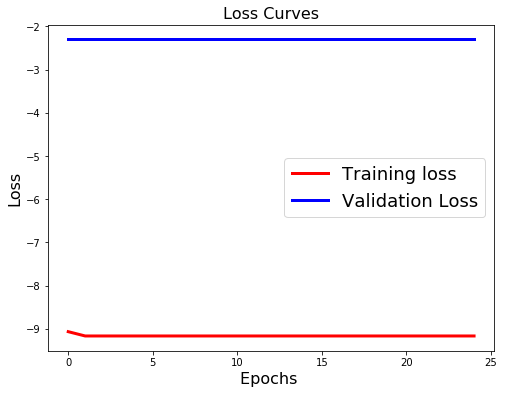

In [22]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_trend.history['loss'],'r',linewidth=3.0)
plt.plot(history_trend.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

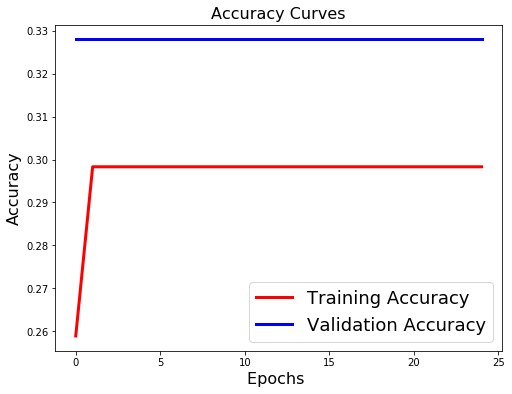

In [23]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_trend.history['binary_accuracy'],'r',linewidth=3.0)
plt.plot(history_trend.history['val_binary_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [118]:
# Vorhersage generieren
testPredict_100 = model.predict(Xtest_100)

In [113]:
def classification(dataset):
    for i in range(len(dataset)):
        if dataset[i]>= 0.05:
            dataset[i]=1
        elif dataset[i]<= -0.05:
            dataset[i]=-1
        else:
            dataset[i]=0
    return dataset

In [114]:
testPredict_100_C=classification(testPredict_100)

In [115]:
accuracy_score(ytest_100, testPredict_100_C)

0.5698924731182796

(array([11., 10., 16., 14., 12., 11., 24., 35., 33., 20.]),
 array([-0.09712184, -0.07689094, -0.05666004, -0.03642914, -0.01619824,
         0.00403266,  0.02426356,  0.04449446,  0.06472536,  0.08495626,
         0.10518716]),
 <a list of 10 Patch objects>)

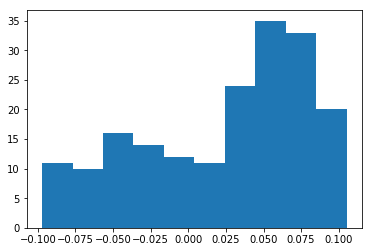

In [119]:
plt.hist(testPredict_100)

(array([26.,  0.,  0.,  0.,  0., 83.,  0.,  0.,  0., 77.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

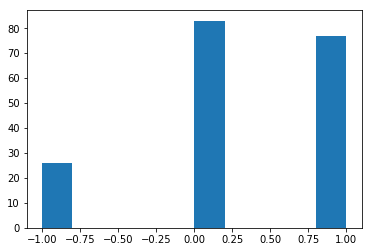

In [117]:
plt.hist(testPredict_100_C)

(array([45.,  0.,  0.,  0.,  0., 61.,  0.,  0.,  0., 80.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

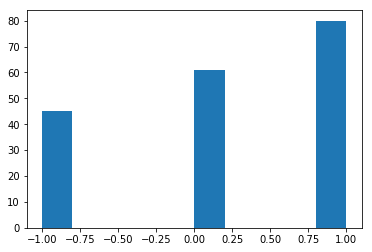

In [63]:
plt.hist(ytest_100)

In [28]:
# Replizierbarkeit gewährleisten
np.random.seed(0)

In [29]:
# Modellanpassung: 
history_trend=model.fit(Xtrain_46, ytrain_46, epochs=200, batch_size=2, validation_data=(Xtest_46, ytest_46))

Train on 188 samples, validate on 68 samples
Epoch 1/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 2/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 3/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 4/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 5/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 6/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
E

Epoch 52/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 53/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 54/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 55/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 56/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 57/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 58/200
188/188 [==================

Epoch 103/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 104/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 105/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 106/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 107/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 108/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 109/200
188/188 [===========

Epoch 154/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 155/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 156/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 157/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 158/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 159/200
188/188 [==============================] - 0s 2ms/step - loss: -12.9459 - binary_accuracy: 0.1117 - val_loss: 1.5942 - val_binary_accuracy: 0.4118
Epoch 160/200
188/188 [===========

Text(0.5,1,'Loss Curves')

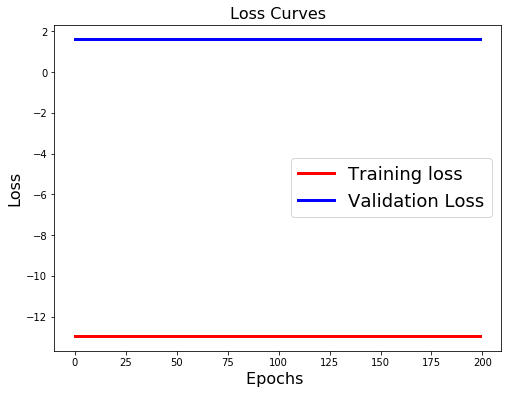

In [30]:
#Ploten der Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history_trend.history['loss'],'r',linewidth=3.0)
plt.plot(history_trend.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5,1,'Accuracy Curves')

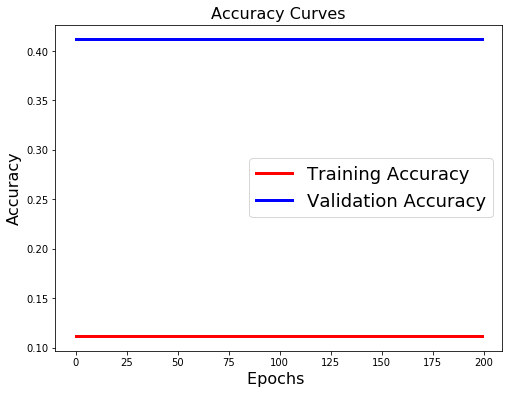

In [31]:
#Plotten der Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history_trend.history['binary_accuracy'],'r',linewidth=3.0)
plt.plot(history_trend.history['val_binary_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [52]:
# Vorhersage generieren
testPredict_46 = model.predict(Xtest_46)

In [50]:
testPredict_46_C=classification(testPredict_46)

In [34]:
accuracy_score(ytest_46, testPredict_46_C)

0.5735294117647058

(array([ 2.,  3.,  3.,  3., 13.,  8.,  9., 12., 10.,  5.]),
 array([0.01987076, 0.0284024 , 0.03693404, 0.04546568, 0.05399732,
        0.06252896, 0.0710606 , 0.07959224, 0.08812388, 0.09665552,
        0.10518716]),
 <a list of 10 Patch objects>)

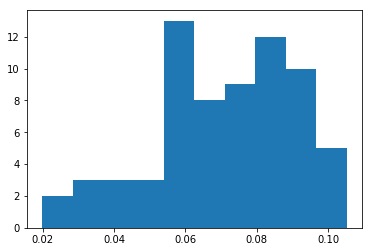

In [55]:
plt.hist(testPredict_46)

(array([11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 57.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

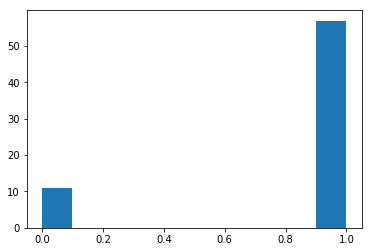

In [56]:
plt.hist(testPredict_46_C)

(array([28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 40.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

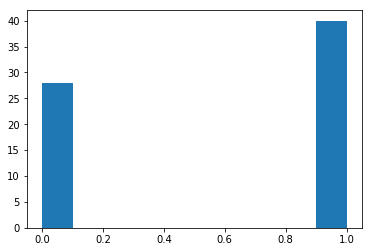

In [57]:
plt.hist(ytest_46)